In [27]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/students-performance-in-2024-jamb/jamb_exam_results.csv


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [29]:
df = pd.read_csv('/kaggle/input/students-performance-in-2024-jamb/jamb_exam_results.csv')

df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


In [30]:
df.shape

(5000, 17)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   JAMB_Score                    5000 non-null   int64  
 1   Study_Hours_Per_Week          5000 non-null   int64  
 2   Attendance_Rate               5000 non-null   int64  
 3   Teacher_Quality               5000 non-null   int64  
 4   Distance_To_School            5000 non-null   float64
 5   School_Type                   5000 non-null   object 
 6   School_Location               5000 non-null   object 
 7   Extra_Tutorials               5000 non-null   object 
 8   Access_To_Learning_Materials  5000 non-null   object 
 9   Parent_Involvement            5000 non-null   object 
 10  IT_Knowledge                  5000 non-null   object 
 11  Student_ID                    5000 non-null   int64  
 12  Age                           5000 non-null   int64  
 13  Gen

In [32]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
JAMB_Score,5000.0,174.07460,47.616477,100.0,135.00,170.0,209.00,367.0
Study_Hours_Per_Week,5000.0,19.52120,9.634569,0.0,13.00,19.0,26.00,40.0
Attendance_Rate,5000.0,84.23520,9.485688,50.0,78.00,84.0,91.00,100.0
Teacher_Quality,5000.0,2.52140,0.985564,1.0,2.00,2.0,3.00,5.0
Distance_To_School,5000.0,10.00546,4.820221,0.0,6.60,10.0,13.40,20.0
Student_ID,5000.0,2500.50000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,18.44580,2.301504,15.0,16.00,18.0,20.00,22.0
Assignments_Completed,5000.0,1.80460,0.992076,1.0,1.00,1.0,2.00,5.0


# EDA

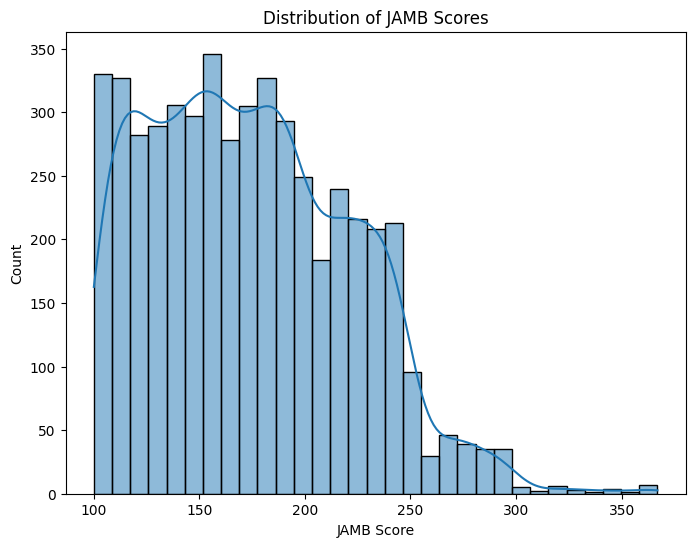

In [33]:
plt.figure(figsize=(8, 6))
sns.histplot(df['JAMB_Score'], kde=True)
plt.title('Distribution of JAMB Scores')
plt.xlabel('JAMB Score')
plt.ylabel('Count')
plt.show()

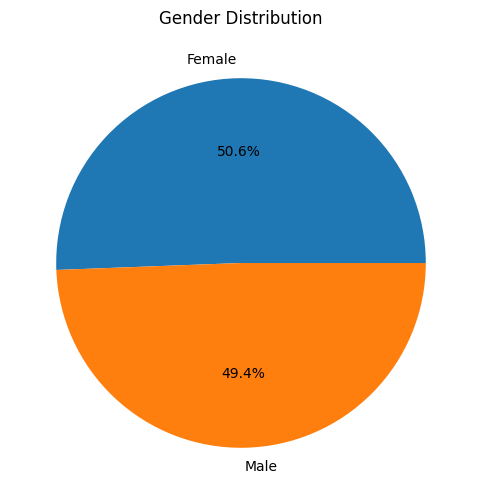

In [34]:
# Pie chart for Gender Distribution
plt.figure(figsize=(6, 6))
df['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.ylabel('')
plt.show()

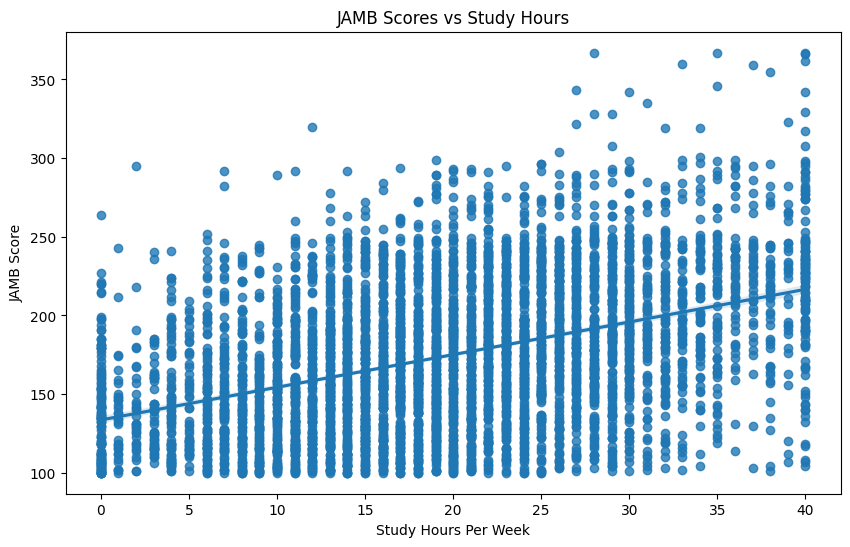

In [35]:
# JAMB Scores vs Study Hours
plt.figure(figsize=(10, 6))
sns.regplot(x='Study_Hours_Per_Week', y='JAMB_Score', data=df)
plt.title('JAMB Scores vs Study Hours')
plt.xlabel('Study Hours Per Week')
plt.ylabel('JAMB Score')
plt.show()

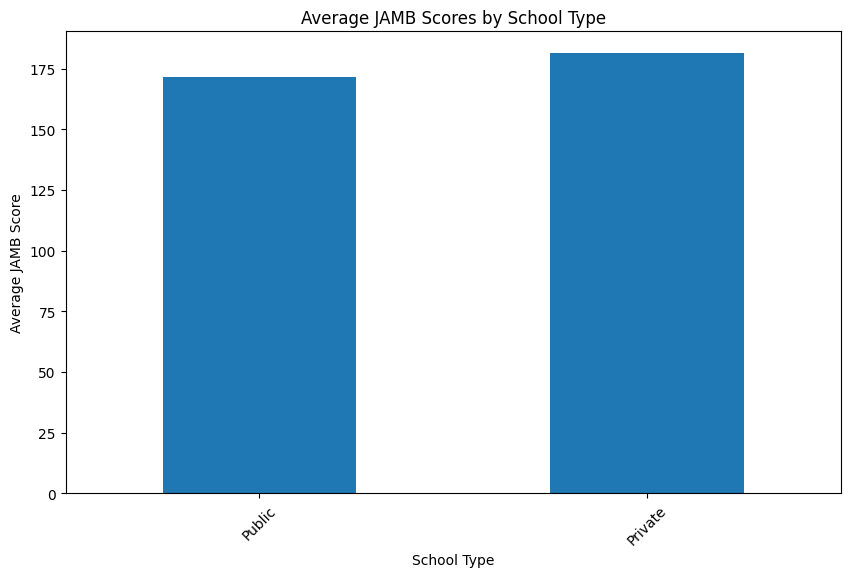

In [36]:
# Average JAMB Scores by School type
plt.figure(figsize=(10, 6))
df.groupby('School_Type')['JAMB_Score'].mean().sort_values().plot(kind='bar')
plt.title('Average JAMB Scores by School Type')
plt.xlabel('School Type')
plt.ylabel('Average JAMB Score')
plt.xticks(rotation=45)
plt.show()

The visualization above indicates that students who attended private educational institutions generally achieve marginally higher scores on the JAMB examination when compared to their counterparts from public or government-operated schools.

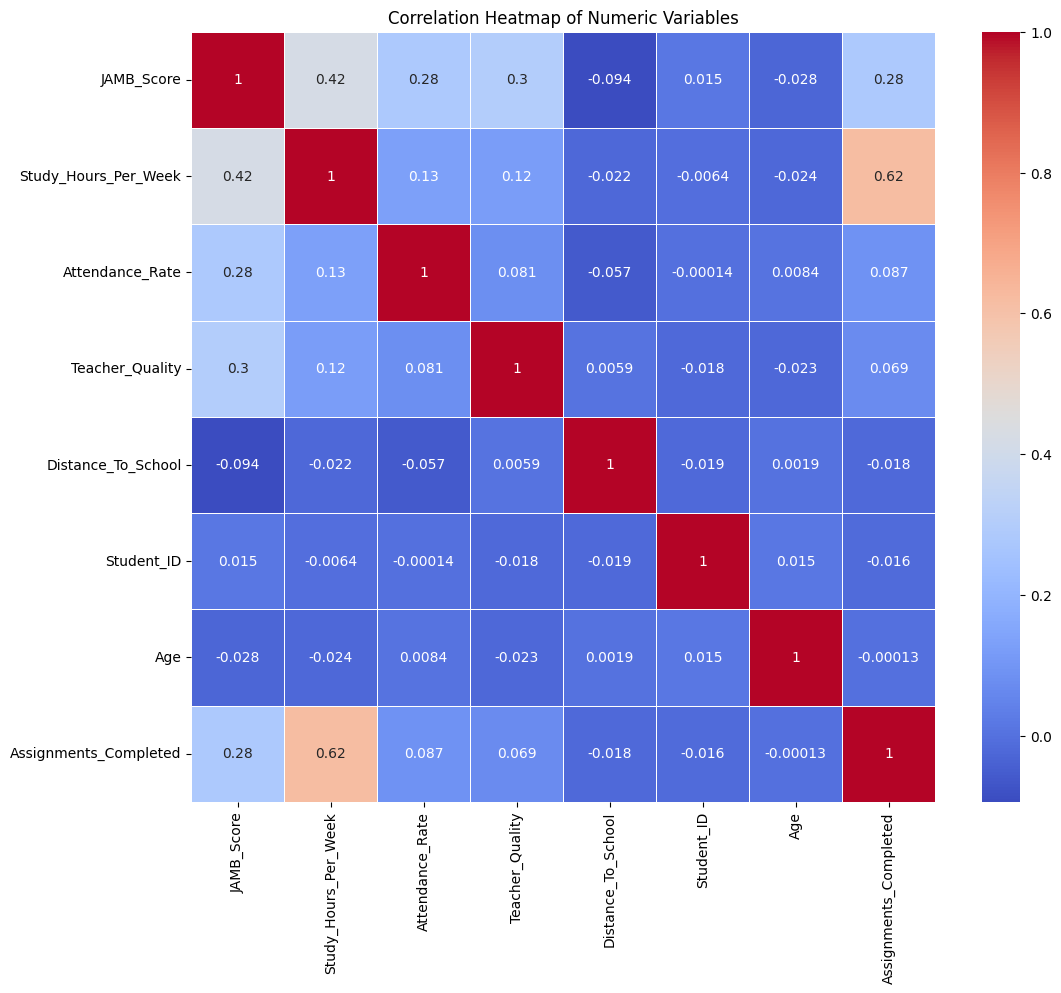

In [37]:
plt.figure(figsize=(12, 10))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

The target variable 'JAMB_Score' shows a strong positive relationship with several numerical predictor variables, including 'Study_Hours_Per_Week', 'Attendance_Rate', 'Teacher_Quality', and 'Assignments_Completed'. This relationship suggests that these factors have a beneficial impact on JAMB scores. As these variables increase, there tends to be a corresponding increase in JAMB scores.

In [38]:
df1 = df.copy()
df1.drop(columns=['Student_ID'], inplace=True)

In [39]:
# creating a test set
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df1, test_size=0.2, random_state=42)

In [40]:
X = train_set.drop(columns =['JAMB_Score'] )
y = train_set['JAMB_Score'].copy() 

In [41]:
X.columns

Index(['Study_Hours_Per_Week', 'Attendance_Rate', 'Teacher_Quality',
       'Distance_To_School', 'School_Type', 'School_Location',
       'Extra_Tutorials', 'Access_To_Learning_Materials', 'Parent_Involvement',
       'IT_Knowledge', 'Age', 'Gender', 'Socioeconomic_Status',
       'Parent_Education_Level', 'Assignments_Completed'],
      dtype='object')

# ML Model

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = make_pipeline(StandardScaler())

num_attribs = ['Student_ID', 'Age', 'Attendance_Rate', 'Assignments_Completed','Distance_To_School', 'Teacher_Quality',
               'Study_Hours_Per_Week']
cat_attribs = ['Gender', 'School_Location', 'Parent_Education_Level','Socioeconomic_Status', 'Access_To_Learning_Materials',
               'Extra_Tutorials', 'IT_Knowledge', 'School_Type']

cat_pipeline = make_pipeline(
    #SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [43]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [44]:
X_prepared = preprocessing.fit_transform(X)

In [45]:
X_prepared_fr = pd.DataFrame(
    X_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=X.index)
X_prepared_fr.head(2)

,pipeline-1__Study_Hours_Per_Week,pipeline-1__Attendance_Rate,pipeline-1__Teacher_Quality,pipeline-1__Distance_To_School,pipeline-1__Age,pipeline-1__Assignments_Completed,pipeline-2__School_Type_Private,pipeline-2__School_Type_Public,pipeline-2__School_Location_Rural,pipeline-2__School_Location_Urban,...,pipeline-2__IT_Knowledge_Medium,pipeline-2__Gender_Female,pipeline-2__Gender_Male,pipeline-2__Socioeconomic_Status_High,pipeline-2__Socioeconomic_Status_Low,pipeline-2__Socioeconomic_Status_Medium,pipeline-2__Parent_Education_Level_Primary,pipeline-2__Parent_Education_Level_Secondary,pipeline-2__Parent_Education_Level_Tertiary,pipeline-2__Parent_Education_Level_nan
4227,0.373330,-1.186535,-1.534327,1.320159,0.667744,-0.80536,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4676,-1.294253,-0.031220,0.488850,-0.136476,1.534943,-0.80536,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [46]:
rf_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42, n_estimators= 100, max_leaf_nodes=50, max_depth=10,      # Added to control tree depth
        min_samples_split=5, min_samples_leaf=2))
rf_reg.fit(X,y) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7cc9f43a55a0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7cc9f43a5fc0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=10, max_leaf_nodes=50,
                                       min_samples_leaf=2, min_samples_split=5,
                                       random_state=42))])

In [47]:
train_predictions = rf_reg.predict(X)

mse = (mean_squared_error(y, train_predictions)) 
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on Training Set: {rmse:.4f}")

Root Mean Squared Error on Training Set: 36.4679


In [48]:
X_test = test_set.drop(columns= ['JAMB_Score'])
y_test = test_set['JAMB_Score']

In [49]:
test_predictions = rf_reg.predict(X_test)

mse2 = (mean_squared_error(y_test, test_predictions)) 
rmse2 = np.sqrt(mse2)
print(f"Root Mean Squared Error on Test Set: {rmse2:.4f}")

Root Mean Squared Error on Test Set: 40.5386


In [50]:
predictions_df = pd.DataFrame() 
predictions_df['actual_score'] = y_test
predictions_df['predicted_score'] = test_predictions 

In [51]:
predictions_df.sample(n=5)

,actual_score,predicted_score
994,122,147.911159
1650,206,186.880170
1870,195,185.019556
4893,237,181.200731
1419,107,169.116525


Improving the model's performance is an continuous process, and I believe there’s still more to uncover.

Thank you for checking this notebook! If you found it helpful, please consider giving it an upvote ⬆️. Your support is greatly appreciated and motivates me to create more valuable content.